# K-Means clustering

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [53]:
# Funciones auxiliares generales
def filtrar_outliers(df, columna, p_inf=0.01, p_sup=0.99):
    """Filtra valores extremos de una columna numérica usando percentiles."""
    lim_inf = df[columna].quantile(p_inf)
    lim_sup = df[columna].quantile(p_sup)
    return df[df[columna].between(lim_inf, lim_sup)]

# Cargar y preparar los datos
def cargar_datos(ruta):
    df = pd.read_csv(ruta)
    df["cholesterol"] = (df["cholesterol"] > 1).astype(int)
    df["gluc"] = (df["gluc"] > 1).astype(int)
    df["age_years"] = (df["age"] / 365).astype(int)
    return df

def agregar_bmi(df):
    """Calcula el IMC y agrega las columnas 'BMI' e 'overweight' al DataFrame."""
    bmi = df["weight"] / ((df["height"] / 100) ** 2)
    df["BMI"] = bmi
    df["overweight"] = (bmi > 25).astype(int)
    return df

In [54]:
ruta = "C:/Users/trezz/Desktop/proyectosDeDesarrolloWeb/MedicalExamination/data/medical_examination.csv"
df = cargar_datos(ruta)
df = agregar_bmi(df)
df = filtrar_outliers(df, "BMI")

In [55]:
# Seleccionar variables para clustering
X = df[["age_years", "BMI", "ap_hi", "ap_lo", "cholesterol", "gluc"]]

In [56]:
# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [57]:
# Aplicar K-Means (ejemplo con 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

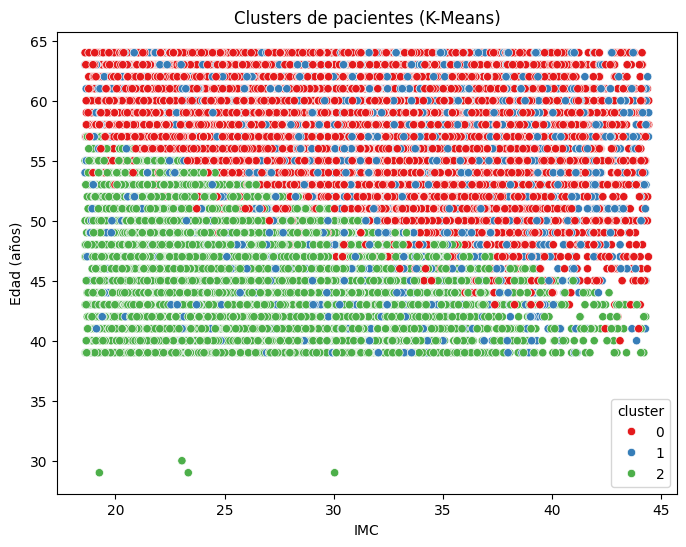

In [58]:
# Visualizar clusters (ej. BMI vs colesterol)
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="BMI", y="age_years", hue="cluster", palette="Set1")
plt.title("Clusters de pacientes (K-Means)")
plt.xlabel("IMC")
plt.ylabel("Edad (años)")
plt.show()

# Cada paciente queda asignado a un grupo según sus características (edad, IMC, presión, colesterol, etc.).

- **Cluster 0** → edad más alta, IMC elevado, presión más alta.

- **Cluster 1** → edad intermedia, IMC moderado.

- **Cluster 2** → edad más baja, IMC más bajo, colesterol/glucosa normales.

In [59]:
# Comparar clusters con enfermedad cardiovascular
cluster_cardio = pd.crosstab(df["cluster"], df["cardio"])
print(cluster_cardio)

cardio       0      1
cluster              
0        13012  19132
1         4022   6223
2        17243   8971


# Analisis de componentes principales (PCA)

In [60]:
# Normalizar
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)   # ajusta el modelo PCA sobre los datos escalados y transforma cada paciente en coordenadas nuevas (PC1, PC2, …, PC6).    

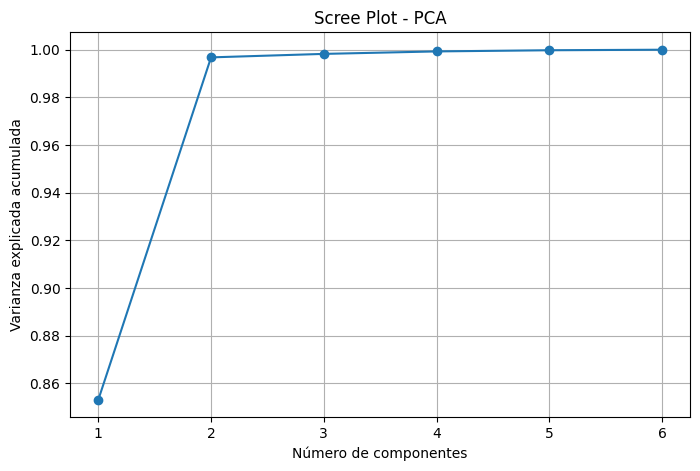

In [61]:
# Scree Plot ayuda a decidir cuántos componentes usar

explained_var = pca.explained_variance_ratio_    # devuelve cuánto porcentaje de la variabilidad total explica cada componente.

# Se grafica la varianza acumulada: cuánto de la información original se conserva si uso 1, 2, 3… componentes.
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), np.cumsum(explained_var), marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Scree Plot - PCA')
plt.grid(True)
plt.show()

<Axes: xlabel='PC1', ylabel='PC2'>

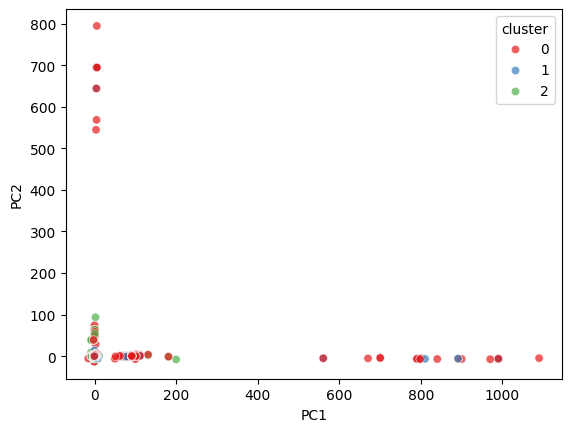

In [62]:
# PCA con 2 componentes para visualización

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

df["PC1"] = X_pca2[:,0]
df["PC2"] = X_pca2[:,1]

sns.scatterplot(x="PC1", y="PC2", hue="cluster", palette="Set1", data=df, alpha=0.7)


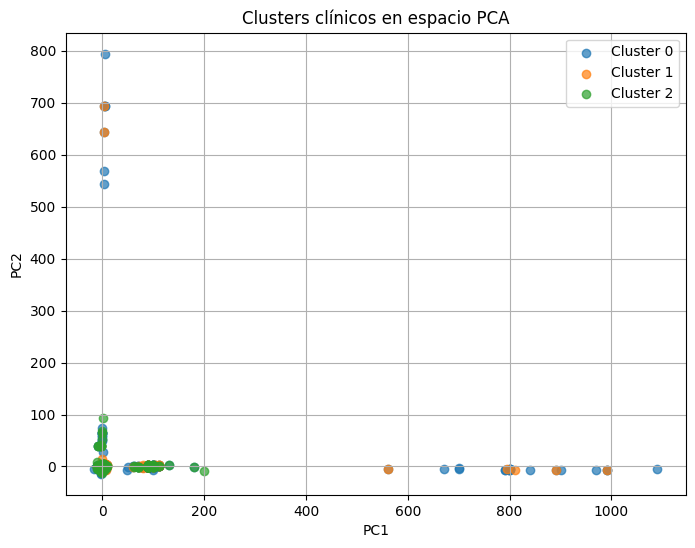

In [63]:
plt.figure(figsize=(8, 6))
for i in range(3):  # tres clusters: 0, 1, 2
    plt.scatter(
        df[df["cluster"] == i]["PC1"],
        df[df["cluster"] == i]["PC2"],
        label=f"Cluster {i}",
        alpha=0.7
    )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters clínicos en espacio PCA")
plt.legend()
plt.grid(True)
plt.show()


In [64]:
# Cargas de cada variable en los componentes principales
loadings = pd.DataFrame(
    pca2.components_.T,
    columns=["PC1", "PC2"],
    index=X.columns
)

print("Cargas (loadings) de cada variable en PC1 y PC2:")
print(loadings)


Cargas (loadings) de cada variable en PC1 y PC2:
                  PC1       PC2
age_years    0.000637  0.001755
BMI          0.001591  0.002722
ap_hi        0.007724  0.999964
ap_lo        0.999968 -0.007731
cholesterol  0.000593  0.001342
gluc         0.000237  0.000564


# Descomposicion de valores singulares

In [65]:
# Definir número de componentes (ejemplo: 2 o 3 para visualizar)
svd = TruncatedSVD(n_components=2, random_state=42)

X_svd = svd.fit_transform(X_scaled)

print("Forma original:", X_scaled.shape)
print("Forma reducida:", X_svd.shape)

Forma original: (68603, 6)
Forma reducida: (68603, 2)


In [66]:
# Varianza explicada por cada componente
print("Varianza explicada:", svd.explained_variance_ratio_)
print("Varianza total explicada:", svd.explained_variance_ratio_.sum())

Varianza explicada: [0.8530483  0.14373589]
Varianza total explicada: 0.9967841869848254


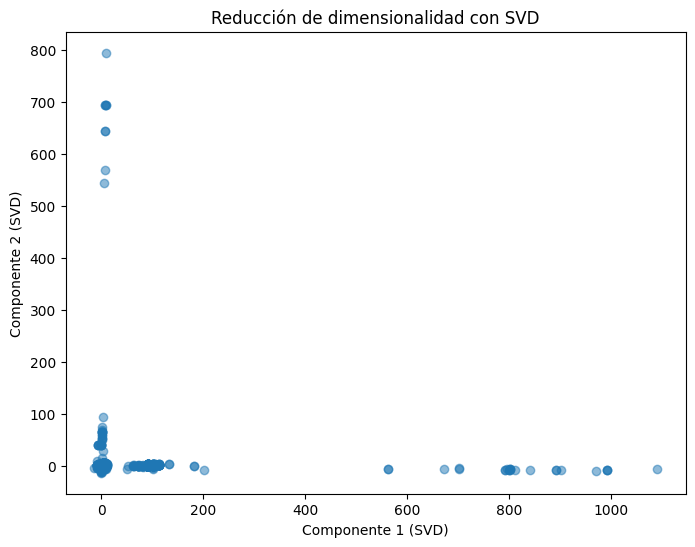

In [67]:
plt.figure(figsize=(8,6))
plt.scatter(X_svd[:,0], X_svd[:,1], alpha=0.5)
plt.xlabel("Componente 1 (SVD)")
plt.ylabel("Componente 2 (SVD)")
plt.title("Reducción de dimensionalidad con SVD")
plt.show()